# Estimator

As in [this paper](https://arxiv.org/abs/1608.00060), the model is
$$Y = \theta T + m_Y(X) + R_Y,$$
$$T = m_T(X) + R_T.$$
with $E[R_Y|X, T] = 0$ and $E[R_T|X] = 0$. To estimate $\theta$,
1. Partition the data set into $I_1$ and $I_2$.
1. For $k=1,2$
    1. Fit $Y$ versus $X$ on $I_k$ to approximate $m_Y$. Compute the residual $\hat{R}_Y = Y - m_Y(X)$ on $I_k^C$.
    1. Fit $T$ versus $X$ on $I_k$ to approximate $m_T$. Compute the residual $\hat{R}_T = T - m_T(X)$ on $I_k^C$.
    1. Fit a linear model for $\hat{R}_Y$ versus $\hat{R}_T$, giving an estimate $\theta_{k}$ for $\theta$.
1. Average $\theta_1$ and $\theta_{2}$.

The paper also suggests an alternative way of estimating $\theta_k$:
* Fit a linear model for $\hat{R}_T \cdot \hat{R}_Y$ versus $\hat{R}_T \cdot T$, giving an estimate $\theta_{k}$ for $\theta$.

In [1]:
class Data():
    """Class containing data frame, treatments, outcomes, and controls."""

    def __init__(self, df, outcomes, treatments, controls=None):
        self.df = df
        self.outcomes = outcomes
        self.treatments = treatments
        
         # Assign remaining columns if controls not set
        self.controls = controls \
            if controls is not None else self._get_non_to()
    
    def _get_non_to(self):
        return [col for col in self.df.columns
                if col not in self.outcomes
                and col not in self.treatments]

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression


class DoubleML():
    
    def __init__(self, n_split=2, n_repeat=1, alternative_approach=False):
        self.n_split = n_split
        self.n_repeat = n_repeat
        self.alternative_approach = alternative_approach
    
    def set_models(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        return self

    def set_data(self, d):
        self.data = d
        return self
    
    def _split_df(self):
        
        # Split
        self._dfs = []
        indices = np.random.permutation(self.data.df.index)
        split = np.array_split(indices, self.n_split)
        for s in split:
            self._dfs.append(self.data.df.loc[s])
        
        return self

    def _get_residual(self, df1, x, y, model):
        
        X1 = df1[x]
        Y1 = df1[y]
        
        # Define complement
        df2 = self.data.df.drop(df1.index)

        X2 = df2[x]
        Y2 = df2[y]
        
        Y2_pred = pd.DataFrame(columns=y, index=df2.index)
        
        # NOTE need to reshape before/after sklearn 
        Y1 = Y1.values.ravel()
        Y2_pred_tmp = model.fit(X1, Y1).predict(X2)
        Y2_pred.loc[:,y] = Y2_pred_tmp.reshape(-1, len(y))
        
        return Y2 - Y2_pred
    
    def _get_coef(self, df1, residual_2, residual_1):
        
        if self.alternative_approach:
            
            # Define complement
            df2 = self.data.df.drop(df1.index)
            X = df2[self.data.treatments]
        
            X = np.dot(residual_2.T, X)
            Y = np.dot(residual_2.T, residual_1)
        
            coef = [np.mean(Y)/np.mean(X)]
        
        else:
        
            # Second vs First Residuals
            coef = LinearRegression()\
                .fit(residual_2, residual_1)\
                .coef_

        return pd.DataFrame(coef, columns=residual_2.columns)
        
    def _crossfit(self, df1):
        
        controls = self.data.controls
        treatments = self.data.treatments
        outcomes = self.data.outcomes
        
        # Treatments vs Controls
        residual_tc = self._get_residual(
            df1, controls, treatments, self.model1
        )
        
        # Outcomes vs Controls
        residual_oc = self._get_residual(
            df1, controls, outcomes, self.model2
        )
        
        # Second vs First Residuals
        return self._get_coef(df1, residual_tc, residual_oc)
    
    def _k_crossfit(self):
        
        coefs = []
        
        for df in self._dfs:
            coef = self._crossfit(df)
            coefs.append(coef)
        
        return pd.concat(coefs).reset_index(drop=True).mean().to_frame().transpose()
        
    def estimate(self):
        
        estimates = []
        for _ in range(self.n_repeat):
            estimate = self._split_df()._k_crossfit()
            estimates.append(estimate)

        return pd.concat(estimates).reset_index(drop=True)

# Example

Let's apply this to the data set. We want to estimate the effect of 401(k) eligibility on net financial assets using double machine learning as in [this paper](https://arxiv.org/abs/1608.00060) with data from [here](https://github.com/kquist/DoubleML-Python).

In [3]:
import pandas as pd

df = pd.read_stata('sipp1991.dta')

print(df.shape)
df.sample(10)

(9915, 14)


,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
1444,11499.0,9499.0,9499.0,29,36300.0,1,16,0,0,0,0,0,0,0
6456,600.0,300.0,66100.0,33,30438.0,4,14,0,1,0,1,0,0,1
5494,8499.0,8499.0,78499.0,48,40410.0,4,9,0,1,1,0,0,0,1
1204,67200.0,72057.0,114057.0,47,74670.0,3,12,0,1,1,0,0,1,1
6539,39419.0,58019.0,124394.0,47,43854.0,2,18,1,0,0,1,1,0,1
8246,103000.0,108600.0,275600.0,43,47796.0,4,11,0,1,0,1,1,1,1
5562,1300.0,-276.0,50224.0,48,52836.0,3,12,0,1,1,0,0,0,1
6488,1549.0,8849.0,12849.0,31,72957.0,2,16,0,1,1,1,1,0,1
9491,4475.0,7575.0,59425.0,53,40494.0,2,14,1,0,0,1,1,0,1
5521,0.0,-9168.0,18832.0,41,14484.0,3,12,0,1,0,0,0,0,1


In [4]:
from sklearn.ensemble import RandomForestRegressor

data = Data(
    df = df,
    outcomes = ["nifa"],
    treatments = ["marr"]
)

model = RandomForestRegressor(max_depth=2)

In [5]:
estimates = (
    DoubleML(n_split=2, n_repeat=20)
    .set_models(model, model)
    .set_data(data)
    .estimate()
)

Let's visualize the distribution of estimates.

              marr
count    20.000000
mean   4317.491601
std     299.561706
min    3902.346937
25%    4099.853498
50%    4293.790491
75%    4419.194167
max    5126.467946


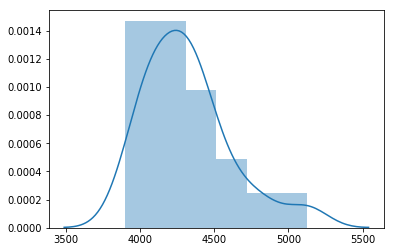

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

def see_distribution(l):

    # estimates.hist(bins=10)
    sns.distplot(l)
    print(l.describe())

see_distribution(estimates)

Let's compare with the alternative way of computing the estimate.

              marr
count    20.000000
mean   4357.721720
std     287.962867
min    3854.063278
25%    4137.630813
50%    4312.712508
75%    4526.178868
max    4903.404141


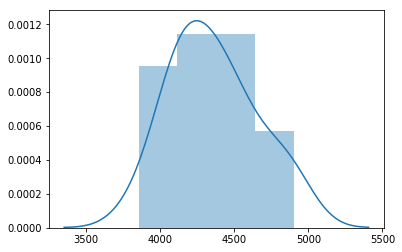

In [7]:
estimates = (
    DoubleML(n_split=2, n_repeat=20, alternative_approach=True)
    .set_models(model, model)
    .set_data(data)
    .estimate()
)

see_distribution(estimates)

# Further Reading

For other examples, see [here](http://aeturrell.github.io/home/2018/02/10/econometrics-in-python-partI-ML/).